In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics as s
from tqdm import tqdm

import cache_magic
%matplotlib inline

In [2]:
DATA_PATH = '../data/'
ANNO_FINE_PATH = DATA_PATH + 'anno_fine'
IMG = DATA_PATH + 'img'

ATTR_CLOTH_LIST_FILE = ANNO_FINE_PATH + '/list_attr_cloth.txt'
ATTR_IMG_LIST_FILE = ANNO_FINE_PATH + '/list_attr_img.txt'
ATTR_TYPES = {'1':"Estampado",'2':"Tipo de manga",'3':"Forma",'4':"Tipo de cuello",'5':"Tejido",'6':"Tallaje"}

NUM_CLASSES = 26

En primer lugar cargamos los datos y construimos una serie de estructuras de datos auxiliares para facilitar el análisis:

In [3]:
# Lectura de la lista de atributos
def read_attr_cloth_list():
    column_to_attr_name = {}
    attr_type_to_columns = {}
    
    with open(ATTR_CLOTH_LIST_FILE) as fp: 
        fp.readline() # Ingorar numero de etiquetas
        fp.readline() # Ignorar cabecera
        column = 0
        for line in fp: 
            fields = line.split()
            attr = fields[0]
            attr_type = fields[1]
            column_to_attr_name[column] = attr
            if attr_type in attr_type_to_columns:
                attr_type_to_columns[attr_type].append(column)
            else:
                attr_type_to_columns[attr_type] = [column]
            column += 1
    return column_to_attr_name, attr_type_to_columns

# Lectura de atributos asociados a una imagen
def read_attr_img_list():
    attr_dict = []
    with open(ATTR_IMG_LIST_FILE) as fp: 
        fp.readline() # Ingorar numero de lineas
        fp.readline() # Ignorar cabecera
        for line in fp:
            row = [int(i) for i in line.split()[1:]]
            attr_dict.append(row)
    return pd.DataFrame.from_records(attr_dict)


In [4]:
column_to_attr_name, attr_type_to_columns = read_attr_cloth_list()           
attr_img_list = read_attr_img_list()
attributes = list(column_to_attr_name.values())

Comprobamos que el número mínimo y máximo de etiquetas asociadas a una imagen es de 6. Esto quiere decir que en esta versión del conjunto de datos cada imagen está asociada siempre a un atributo de cada uno de los seis tipos. 

In [5]:
# Análisis del número mínimo y máximo de atributos que puede tener una imagen
num_attr_per_img = (attr_img_list == 1).astype(int).sum(axis=1)
print(min(num_attr_per_img))
print(max(num_attr_per_img))

6
6


Analizamos las frecuencias de aparición de los atributos, clasificados por su tipo de atributo.

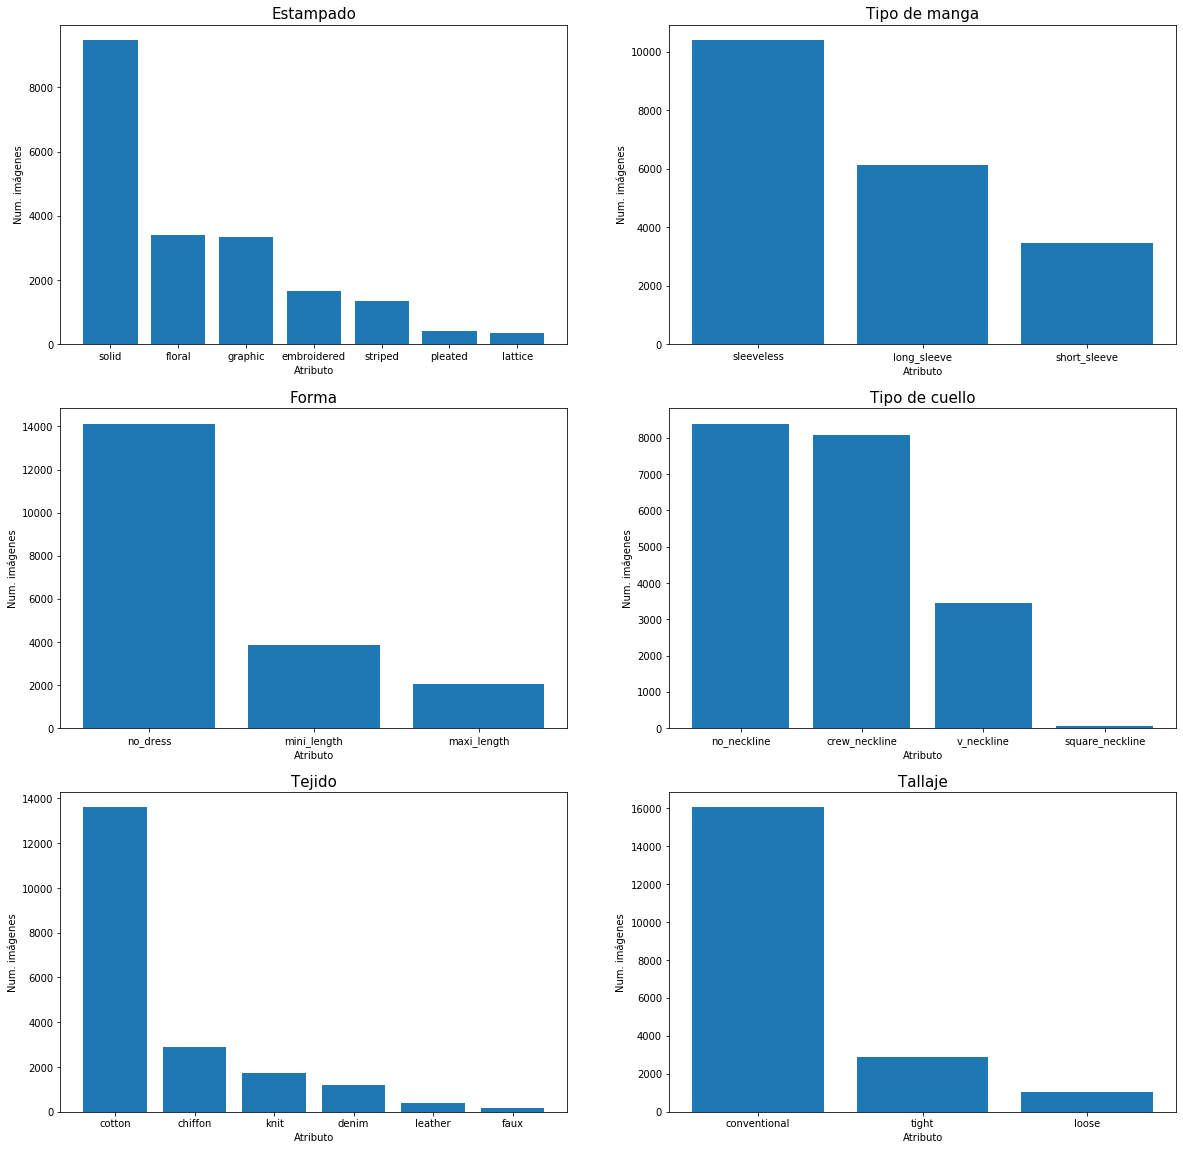

In [6]:
# Análisis de frecuencias dentro de cada tipo de atributo
num_occ_per_attr = (attr_img_list == 1).astype(int).sum(axis=0)
num_occ_per_attr.loc[1]
count = 0
figs = []
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

for attr_type, columns in attr_type_to_columns.items():
    labels = [column_to_attr_name[c] for c in columns]
    counts = [num_occ_per_attr.loc[c] for c in columns]
    
    r = count // 2
    c = count % 2
    
    df = pd.DataFrame(counts, index=labels, columns=["count"])
    df = df.sort_values(by=['count'], ascending=False)
    
    axs[r, c].set_title(ATTR_TYPES[attr_type], fontsize=15)
    axs[r, c].set(xlabel='Atributo', ylabel='Num. imágenes')
    axs[r, c].bar(df.index.values,df['count'])
    count += 1
#plt.show()    
plt.savefig('foo.png')

Esta versión del conjunto de datos dispone de un particionado de los datos para entrenamiento, validación y test. Vamos a comprobar si todas las particiones tienen aproximádamente la misma frecuencia de todos los atributos. 

In [7]:
def build_partition_distribution_table():

     # Carga de las anotaciones reales de la partición de entrenamiento
    partition_attribute_filepath = ANNO_FINE_PATH + "/train_attr.txt"
    y_true_train = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)
    
     # Carga de las anotaciones reales de la partición de valiación
    partition_attribute_filepath = ANNO_FINE_PATH + "/val_attr.txt"
    y_true_val = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)
    
    # Carga de las anotaciones reales de la partición de test
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_test = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)

    # Columna de tipo de atributo
    attr_types = []
    for k, v in attr_type_to_columns.items():
        attr_types.extend([ATTR_TYPES[str(k)]] * len(v))

    # Columnas de frecuencia real
    frequency_train = y_true_train.sum().tolist()
    frequency_val = y_true_val.sum().tolist()
    frequency_test = y_true_test.sum().tolist()

    # Creación de dataframe
    d = {'Atributo': attributes, 'Tipo': attr_types, 'Frecuencia train' : frequency_train, 
         'Frecuencia val' : frequency_val, 'Frecuencia test': frequency_test}
    return pd.DataFrame(data=d)

In [8]:
build_partition_distribution_table()

,Atributo,Tipo,Frecuencia train,Frecuencia val,Frecuencia test
0,floral,Estampado,2383,355,664
1,graphic,Estampado,2329,349,668
2,striped,Estampado,938,117,292
3,embroidered,Estampado,1179,150,338
4,pleated,Estampado,296,40,78
5,solid,Estampado,6633,951,1898
6,lattice,Estampado,242,38,62
7,long_sleeve,Tipo de manga,4269,605,1243
8,short_sleeve,Tipo de manga,2437,351,686
9,sleeveless,Tipo de manga,7294,1044,2071


Vemos que los datos se distribuyen aproximádamente con la misma frecuencia en todas las particiones por lo que se empleará este particionado y no se hará un particionado propio. 

# Data imbalance

Como se aprecia en el dataframe anterior, existe una gran diferencia entre la frecuencia de aparición de ciertos atributos. Por ejemplo, dentro del tipo de cuello, *crew_neckline* aparece más de 5000 veces mientras que *square_neckline* aparece únicamente en 47 ocasiones. Dado que los clasificadores basados en redes neuronales no trabajan bien con datos desbalanceados puesto que no identifican bien los atributos minoritarios, emplearemos varias técnicas para tratar de reducir el impacto de este problema.

## Opción 1: Class weight

Se asignarán pesos de forma inversamente proporcional al número de apariciones de una etiqueta dentro de la partición de entrenamiento. Supongamos, por ejemplo, una muestra de 20 observaciones donde la etiqueta A tiene valor positivo en 10 de ellas y la etiqueta B en 2 de ellas. Los pesos calculados serían:
* A: 20/10 = 2
* B: 20/2 = 10

El cálculo se realiza a partir de la partición de entrenamiento. Los valores se pasan como parámetro a la función *fit_generator* durante el entrenamiento del modelo. No ha sido necesaria la creación de una versión modificada de la partición de entrenamiento. 

## Opción 2: Oversampling y undersampling por etiqueta

En segundo lugar vamos a hacer oversampling de los atributos minoritarios y undersampling de los mayoritarios. Esto no es sencillo en el caso de clasificación multilabel puesto que ambos pueden aparecer en una misma observación. Para ello se ha establecido un algoritmo de ranking, en el que a cada observación se le asigna una puntuación en función de la frecuencia de aparición de los atributos con valor positivo que la forman. 

El procedimiento que se seguirá en este caso es el siguiente:
- Se ordenarán los atributos de un mismo tipo de atributo en base al número de ocurrencias, y se le asignará un peso en base a la posición en esa ordenación. Por ejemplo, en el caso de tener las siguientes etiquetas con el siguiente número de observaciones: {A:10, B:40, C:20, D:60}, los pesos serían: {A:1/4, B:3/4, C:2/4, D:4/4} = {A:0.25, C:0.5, B:0.75, D:1}
- Se calcula la puntuación de las observaciones. La puntuación de una observación es la suma de la multiplicación de los atributos con 1s por su peso correspondiente.
- Para un 30% del dataset, de forma iterativa en batches de 200 elementos:
    - Se ordenan las observaciones por su peso. 
    - Se calcula el percentil 25 y 75 del peso de las observaciones
    - Se eliminan 200 elementos de forma aleatoria y ponderada en base al peso, de las observaciones cuyo peso es superior al p75.
    - Se duplican 200 elementos de forma aleatoria y ponderada en base al peso inverso, de las observaciones cuyo peso es inferior al p25. 
    
Siguiendo este procedimiento, en cada iteración se eliminan observaciones formadas por atributos mayoritarios y se duplican observaciones formadas por atributos minoritarios.  

In [9]:
# Recupera el fichero con el dataframe de atributos por imagen, y añade la columna filename
def get_train_data():
    partition_attribute_filepath = ANNO_FINE_PATH + "/train_attr.txt"
    data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = attributes , index_col=False)
    
    data['filename'] = [str(i) + '.jpg' for i in range(0,len(data))]
    return data

# Genera array de pesos ordenando los atributos dentro de su tipo de atributo en base al número de ocurrencias
# en la partición de train.
def get_attribute_weights():
    df = build_partition_distribution_table()
    d = {}
    for i,attr_type in ATTR_TYPES.items():
        attr_type_df = df.loc[df['Tipo'] == attr_type].sort_values(by=['Frecuencia train'])

        attr_type_df['weight'] = np.arange(len(attr_type_df))
        r, c = attr_type_df.shape
        attr_type_df['weight'] = attr_type_df['weight'].apply(lambda x: x/c)
        s = pd.Series(attr_type_df.weight.values,index=attr_type_df.Atributo).to_dict()
        d.update(s)
        
    r = [d[v] for v in column_to_attr_name.values()]
    return r

# Aplica el array de pesos a las etiquetas positivas de una fila del dataframe
def rank(row, weights):
    r = 0
    for i,w in enumerate(weights):
        r+=row[i]*w
    return r

TO_REPLACE = 4200 # 30% del dataset
BATCH_SIZE = 200
NUM_BATCHES = TO_REPLACE // BATCH_SIZE

def get_oversampled_dataset():
    # Importa el dataframe
    train = get_train_data()
    # Genera array de pesos por atributo
    weights = get_attribute_weights()

    # Añade columna con el ranking y ranking inverso de cada columna
    train['rank'] = train.apply(lambda x: rank(x, weights),axis=1)
    train['rank_inv'] = train.apply(lambda x: 1/rank(x, weights),axis=1)
    
    train = train.sort_values(by=['rank'])
    
    for i in range(0, NUM_BATCHES):
        
        p_25 = np.percentile(train['rank'], 25)
        p_75 = np.percentile(train['rank'], 75)
    
        # Undersampling - Elimina N columnas aleatorias dentro de aquellas con un ranking superior al p75
        train = train.drop(train[train['rank'] > p_75].sample(n=BATCH_SIZE, weights='rank', random_state=1).index)
        # Oversampling - Duplica N columnas aleatorias dentro de aquellas con un ranking inferior al p25
        train = train.append(train[train['rank'] < p_25].sample(n=BATCH_SIZE, weights='rank_inv', random_state=1), ignore_index = True)

    train = train.sort_values(by=['rank'])
    train = train.drop(columns=['rank', 'rank_inv'])
    return train

def show_frequencies(df):
    attr_types = []
    for k, v in attr_type_to_columns.items():
        attr_types.extend([ATTR_TYPES[str(k)]] * len(v))

    # Columnas de frecuencia real
    df = df.drop(columns=['filename'])
    frequency_train = df.sum().tolist()

    # Creación de dataframe
    d = {'Atributo': attributes, 'Tipo': attr_types, 'Frecuencia train' : frequency_train}
    return pd.DataFrame(data=d)

Generamos y persistimos la versión modificada del dataset.

In [10]:
df = get_oversampled_dataset()
# Guardamos en fichero para ser usado desde otro notebook
df.to_csv(ANNO_FINE_PATH + "/train_attr_v2.txt", index=False, header=True, sep=' ')

In [11]:
show_frequencies(df)

,Atributo,Tipo,Frecuencia train
0,floral,Estampado,1849
1,graphic,Estampado,2223
2,striped,Estampado,2069
3,embroidered,Estampado,2008
4,pleated,Estampado,843
5,solid,Estampado,3991
6,lattice,Estampado,1017
7,long_sleeve,Tipo de manga,5198
8,short_sleeve,Tipo de manga,3817
9,sleeveless,Tipo de manga,4985


Se observa que aún existe una diferencia significativa entre los atributos mayoritarios y minoritarios. Sin embargo, la frecuencia de aparición de los mayoritarios ha disminuido y se ha incrementado la de los minoritarios. 

# Opcion 3: Una observación por combinación de etiquetas

Esta opción se basa en el problema de [One-shot learning](https://en.wikipedia.org/wiki/One-shot_learning) de visión por computador en el que el modelo se entrena a partir de observaciones únicas. Aplicado al problema actual, se entrenará el modelo a partir de combinaciones de atributos únicas.  Para ello, se va a descartar combinaciones duplicadas y con ello, como se muestra a continuación, se reduce en un orden de magnitud la diferencia entre la frecuencia de aparición de los atributos minoritarios y mayoritarios. También se reduce de forma significativa el volumen de datos sobre el que se realiza el entrenamiento: el número de observaciones se reduce de 14000 a 905.

In [12]:
df = get_train_data()
df = df.drop_duplicates(subset=attributes)
print('Número de combinaciones de atributos distintas: {}'.format(len(df)))
# Guardamos en fichero para ser usado desde otro notebook
df.to_csv(ANNO_FINE_PATH + "/train_attr_v3.txt", index=False, header=True, sep=' ')
    
show_frequencies(df)

Número de combinaciones de atributos distintas: 905


,Atributo,Tipo,Frecuencia train
0,floral,Estampado,162
1,graphic,Estampado,135
2,striped,Estampado,106
3,embroidered,Estampado,142
4,pleated,Estampado,69
5,solid,Estampado,242
6,lattice,Estampado,49
7,long_sleeve,Tipo de manga,318
8,short_sleeve,Tipo de manga,231
9,sleeveless,Tipo de manga,356


# Opción 4: N observaciones por combinaciones de etiquetas sin oversampling

Esta alternativa es un variante de la opción 3, en la que se permite un máximo de N observaciones con una misma combinación de atributos. En primer lugar, comprobamos como se distribuyen las combinaciones:

In [13]:
def get_train_data_without_duplicates():
    df = get_train_data()
    unique_with_count = df.groupby(attributes).size().reset_index().rename(columns={0:'count'})
    return unique_with_count

unique_with_count = get_train_data_without_duplicates()

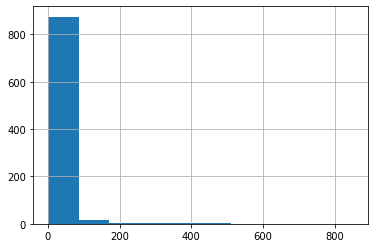

In [14]:
unique_with_count["count"].hist()

In [15]:
print('Media: {}'.format(unique_with_count["count"].mean()))
print('Mediana: {}'.format(unique_with_count["count"].median()))

Media: 15.469613259668508
Mediana: 3.0


In [16]:
for i in range(1,21):
    count = len(unique_with_count[(unique_with_count['count']==i)])
    print('{} attribute combinations with {} samples'.format(count, i))

284 attribute combinations with 1 samples
121 attribute combinations with 2 samples
85 attribute combinations with 3 samples
58 attribute combinations with 4 samples
38 attribute combinations with 5 samples
32 attribute combinations with 6 samples
32 attribute combinations with 7 samples
14 attribute combinations with 8 samples
13 attribute combinations with 9 samples
10 attribute combinations with 10 samples
8 attribute combinations with 11 samples
14 attribute combinations with 12 samples
8 attribute combinations with 13 samples
16 attribute combinations with 14 samples
10 attribute combinations with 15 samples
13 attribute combinations with 16 samples
11 attribute combinations with 17 samples
7 attribute combinations with 18 samples
9 attribute combinations with 19 samples
4 attribute combinations with 20 samples


Definimos el código para la creación del dataframe modificado

In [17]:

def is_equal(x,y):
    for a in attributes:
        if(x[a] != y[a]):
            return False
    return True

def remove_duplicates_above_threshold(size, upsample=False):
    # Encuentra las combinaciones de atributos únicas
    unique_with_count = get_train_data_without_duplicates()
    r = None
    
    # Por cada combinación, se queda con las "size" primeras lineas con la combinación en el dataset.
    # En el caso de que el número de observaciones sea menor, hace oversampling realizando las copias necesariars
    for index, row in tqdm(unique_with_count.iterrows()):
        count = row['count']
        
        # Busqueda de filas
        matching = df[df.apply(lambda x: is_equal(x, row) , axis=1)]
        
        # Oversampling si se pide por parámetro y si el número de filas con la combinación es menor que el pedido
        
        if upsample and len(matching) < size:
            n = (size // len(matching)) + 1
            matching = matching.loc[matching.index.repeat(n)]
    
        # Guardar únicamente "size" filas con la combinación
        found = matching.head(n=size)
        if r is None:
            r = found
        else:
            r = r.append(found, ignore_index = True)
    return r

Se generan 3 versiones en las que se mantiene como máximo 3, 5 y 10 observaciones de cada combinación de atributos. 

In [18]:
%cache unique_n3 = remove_duplicates_above_threshold(3)
%cache unique_n5 = remove_duplicates_above_threshold(5)
%cache unique_n10 = remove_duplicates_above_threshold(10)
%cache unique_n15 = remove_duplicates_above_threshold(15)

unique_n3.to_csv(ANNO_FINE_PATH + "/train_attr_v4_3.txt", index=False, header=True, sep=' ')
unique_n5.to_csv(ANNO_FINE_PATH + "/train_attr_v4_5.txt", index=False, header=True, sep=' ')
unique_n10.to_csv(ANNO_FINE_PATH + "/train_attr_v4_10.txt", index=False, header=True, sep=' ')
unique_n15.to_csv(ANNO_FINE_PATH + "/train_attr_v4_15.txt", index=False, header=True, sep=' ')

Loading cached value for variable 'unique_n3'. Time since caching: 2 days, 20:51:16.020890
Loading cached value for variable 'unique_n5'. Time since caching: 2 days, 20:35:01.555817
Loading cached value for variable 'unique_n10'. Time since caching: 2 days, 20:24:27.213742
Loading cached value for variable 'unique_n15'. Time since caching: 1 day, 5:10:00.662795


Mostramos como ejemplo las frecuencias del dataset modificado con n=3

In [19]:
show_frequencies(unique_n3)

,Atributo,Tipo,Frecuencia train
0,floral,Estampado,371
1,graphic,Estampado,296
2,striped,Estampado,218
3,embroidered,Estampado,332
4,pleated,Estampado,134
5,solid,Estampado,580
6,lattice,Estampado,95
7,long_sleeve,Tipo de manga,714
8,short_sleeve,Tipo de manga,490
9,sleeveless,Tipo de manga,822


# Opción 5: N observaciones por combinación de etiquetas con oversampling

Esta opción es una variante del apartado anterior en las que se permite como máximo N observaciones con la misma combinación de atributos, y en las que se hace oversampling de las combinaciones con un número de observaciones inferior. Este oversampling se realiza duplicando alguna de las observaciones existentes con la misma combinación de atributos. 

Como resultado, con esta técnica se consigue que todas las combinaciones de atributos presentes en el dataset original con el que se entrena el modelo tengan el mismo número de observaciones.

In [20]:
RESET = False
if RESET:
    %cache -r unique_n3_up
    %cache -r unique_n5_up
    %cache -r unique_n10_up
    %cache -r unique_n15_up
    
%cache unique_n3_up = remove_duplicates_above_threshold(3, upsample=True)
%cache unique_n5_up = remove_duplicates_above_threshold(5, upsample=True)
%cache unique_n10_up = remove_duplicates_above_threshold(10, upsample=True)
%cache unique_n15_up = remove_duplicates_above_threshold(15, upsample=True)

unique_n3_up.to_csv(ANNO_FINE_PATH + "/train_attr_v5_3.txt", index=False, header=True, sep=' ')
unique_n5_up.to_csv(ANNO_FINE_PATH + "/train_attr_v5_5.txt", index=False, header=True, sep=' ')
unique_n10_up.to_csv(ANNO_FINE_PATH + "/train_attr_v5_10.txt", index=False, header=True, sep=' ')
unique_n15_up.to_csv(ANNO_FINE_PATH + "/train_attr_v5_15.txt", index=False, header=True, sep=' ')

Loading cached value for variable 'unique_n3_up'. Time since caching: 1 day, 3:37:44.499765
Loading cached value for variable 'unique_n5_up'. Time since caching: 1 day, 3:37:02.657364
Loading cached value for variable 'unique_n10_up'. Time since caching: 1 day, 3:36:21.028302
Loading cached value for variable 'unique_n15_up'. Time since caching: 1 day, 3:35:37.444362


Mostramos las frecuencias con las que aparecen los atributos para la versión generada con n=3

In [21]:
show_frequencies(unique_n3_up)

,Atributo,Tipo,Frecuencia train
0,floral,Estampado,486
1,graphic,Estampado,405
2,striped,Estampado,318
3,embroidered,Estampado,426
4,pleated,Estampado,207
5,solid,Estampado,726
6,lattice,Estampado,147
7,long_sleeve,Tipo de manga,954
8,short_sleeve,Tipo de manga,693
9,sleeveless,Tipo de manga,1068
